<a href="https://colab.research.google.com/github/jeelkukadiya/CodSoft-internship_ML/blob/main/Task_2_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T105905Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ee5d2b1ce47ce5f533eedef99faa21dd624fedd737f2480b2ac6e1e52c23ddc39fe3bb4cdb1a009632867d46f2f8d314bd8aacbe445904b7eb62676b7ecda513aa535c01a004ec292da313e92ab98931936235af2a00a903679bd427e58370744a7c94fbfb5a17cfefa4d6a604f528d01b5df8779e41ac93c89108fdffffa8ddca318903036cdddefeb9b1deabf10b611985c1189fe742253983f698f0f051904541014320d295e10b3a97d9f3c28eea29592903d7d07746e55713e199a927170ffddb4b4ff0d7ae6c0f0674293a0f4aafcf7597f90058b9a272b80a0fe664896fa9ea278c2b343143f28347ef60959d410e298337ddd88ea85d8ced74c7fd2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

# Display basic information about the datasets
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())



Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  l

In [4]:
# Display the first few rows of the train dataset
print("\nTrain Data Sample:")
print(train_data.head())


Train Data Sample:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Green

In [5]:

# Check for missing values in both datasets
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Missing Values in Train Data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Missing Values in Test Data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state   

In [6]:

# Check for missing values in both datasets
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Missing Values in Train Data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Missing Values in Test Data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state   

In [7]:
print(test_data.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [8]:
# Removing rows with missing values
# ---------------------------------
# because it's just single row in each set,
# that's why there will no huge data loss.
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [9]:
# Display summary statistics of the train dataset
print("\nTrain Data Summary Statistics:")
print(train_data.describe())


Train Data Summary Statistics:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std    1.375908e+01

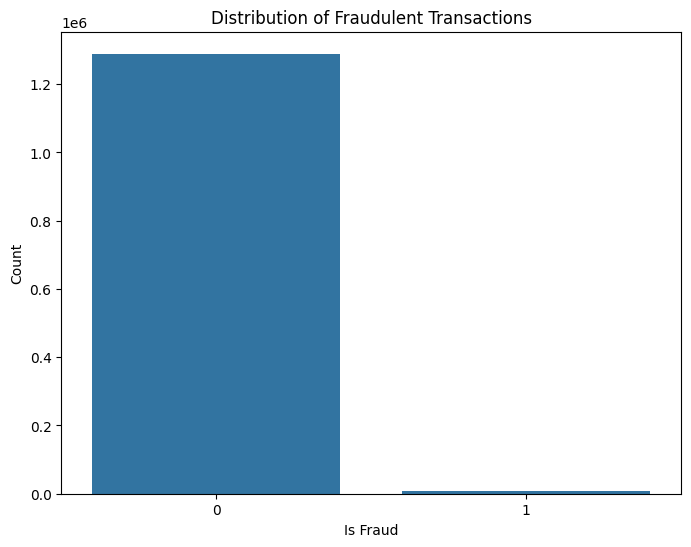

In [10]:
# Visualize the distribution of the target variable (fraudulent or not)
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=train_data)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

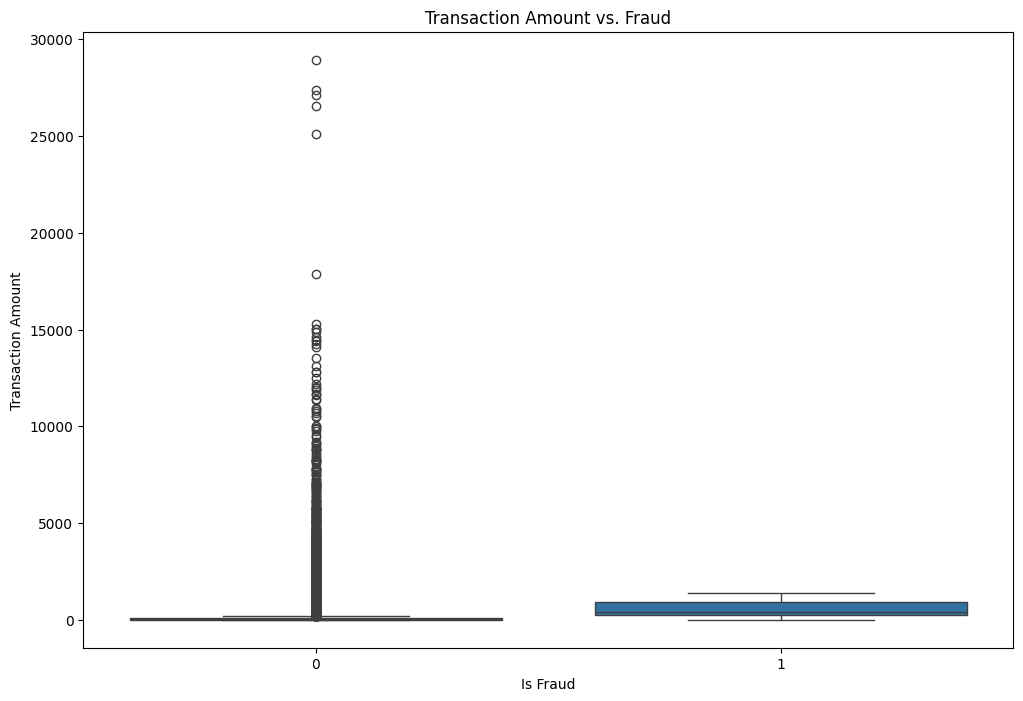

In [11]:
# Explore the distribution of transaction amounts by fraud status
plt.figure(figsize=(12, 8))
sns.boxplot(x='is_fraud', y='amt', data=train_data)
plt.title('Transaction Amount vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

In [12]:

# Explore the correlation between numerical features
#corr_matrix = train_data.corr()
#plt.figure(figsize=(12, 10))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix')
#plt.show()

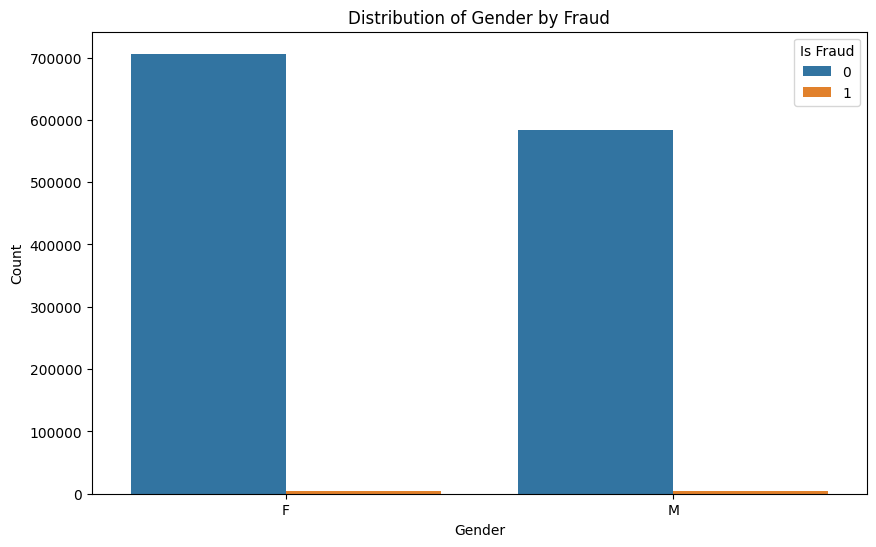

In [13]:
# Explore categorical features (e.g., gender)
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='is_fraud', data=train_data)
plt.title('Distribution of Gender by Fraud')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()

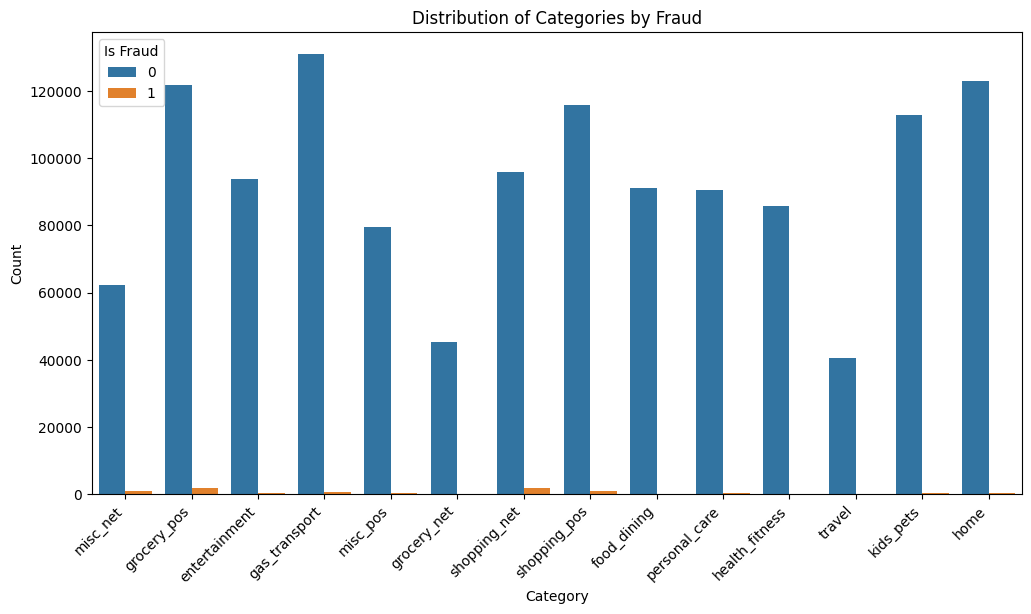

In [14]:
# Explore categorical features (e.g., category)
plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='is_fraud', data=train_data)
plt.title('Distribution of Categories by Fraud')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Is Fraud')
plt.show()

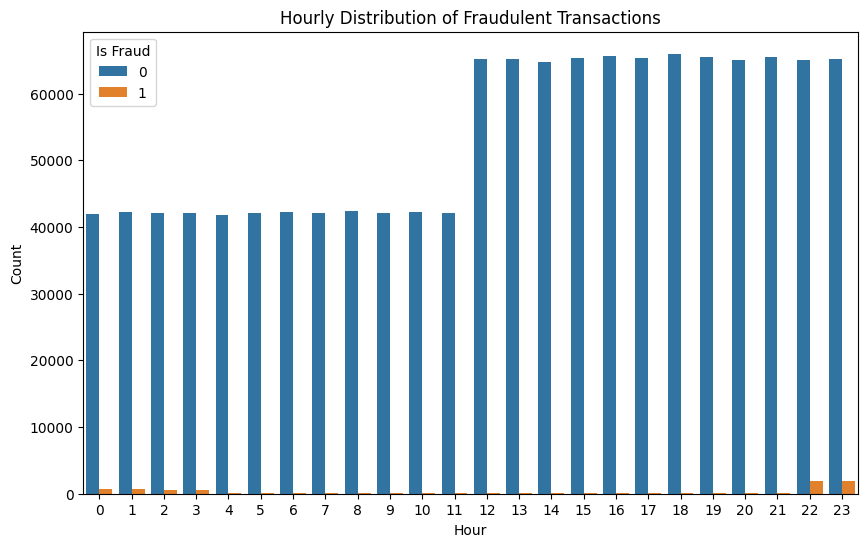

In [15]:
# Time analysis: Extract hours and days from 'trans_date_trans_time'
train_data['trans_hour'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.hour
train_data['trans_day'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.dayofweek

# Plot hourly distribution of fraud
plt.figure(figsize=(10, 6))
sns.countplot(x='trans_hour', hue='is_fraud', data=train_data)
plt.title('Hourly Distribution of Fraudulent Transactions')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()

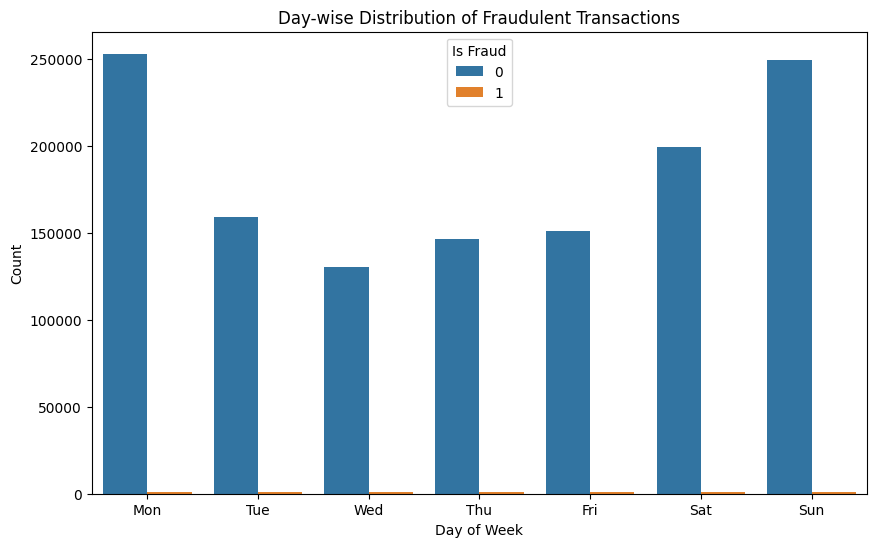

In [16]:
# Plot day-wise distribution of fraud
plt.figure(figsize=(10, 6))
sns.countplot(x='trans_day', hue='is_fraud', data=train_data)
plt.title('Day-wise Distribution of Fraudulent Transactions')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Is Fraud')
plt.show()

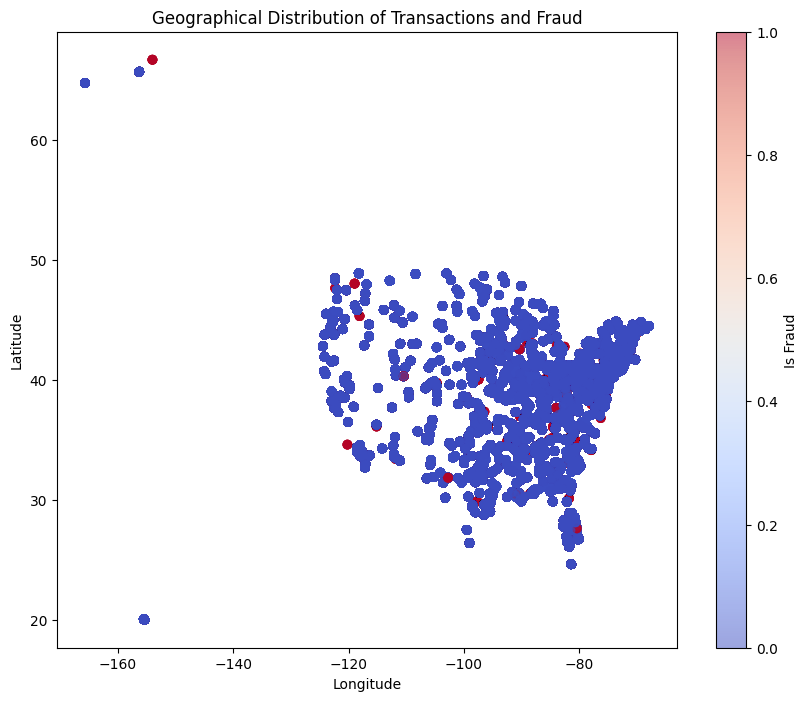

In [17]:
# Scatter plot of geographical data
plt.figure(figsize=(10, 8))
plt.scatter(train_data['long'], train_data['lat'], c=train_data['is_fraud'], cmap='coolwarm', alpha=0.5)
plt.title('Geographical Distribution of Transactions and Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Is Fraud')
plt.show()

<Figure size 1000x600 with 0 Axes>

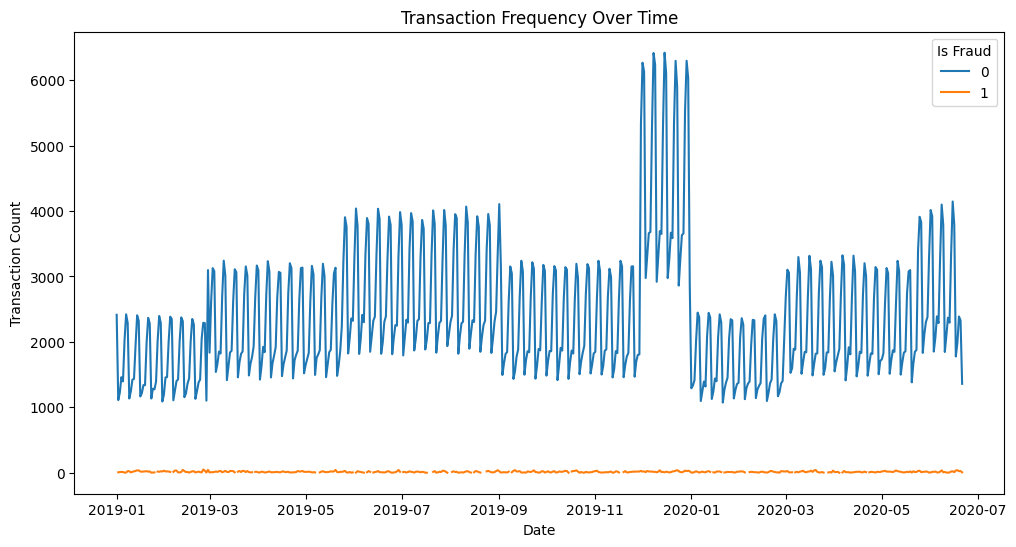

In [18]:
# Transaction Frequency Analysis
plt.figure(figsize=(10, 6))
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['trans_date'] = train_data['trans_date_trans_time'].dt.date
transaction_counts = train_data.groupby(['trans_date', 'is_fraud']).size().unstack()
transaction_counts.plot(kind='line', figsize=(12, 6))
plt.title('Transaction Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.legend(title='Is Fraud')
plt.show()

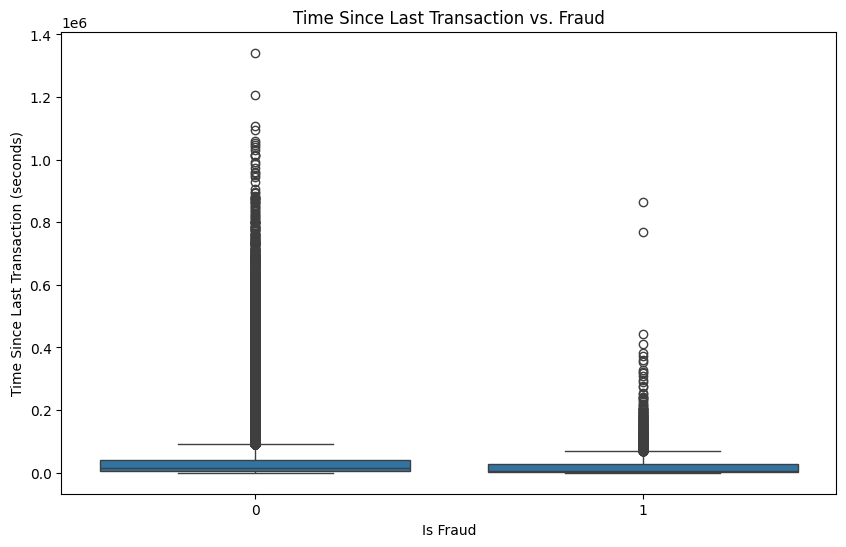

In [19]:
# Transaction Velocity Analysis
train_data['time_since_last_transaction'] = train_data.groupby('cc_num')['unix_time'].diff()
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='time_since_last_transaction', data=train_data)
plt.title('Time Since Last Transaction vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Time Since Last Transaction (seconds)')
plt.show()

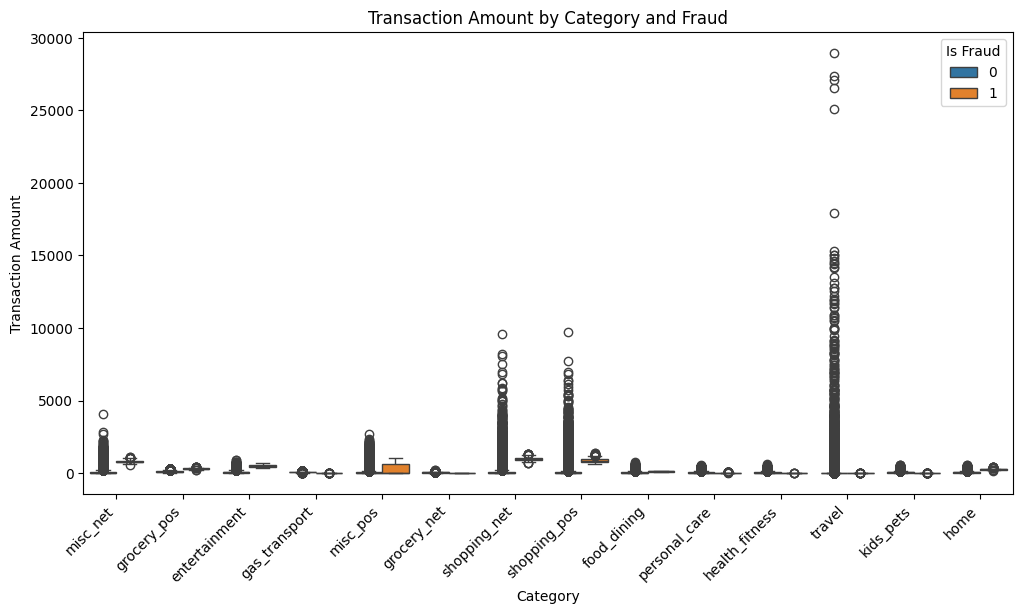

In [20]:
# Transaction Amount by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='amt', hue='is_fraud', data=train_data)
plt.title('Transaction Amount by Category and Fraud')
plt.xlabel('Category')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Is Fraud')
plt.show()

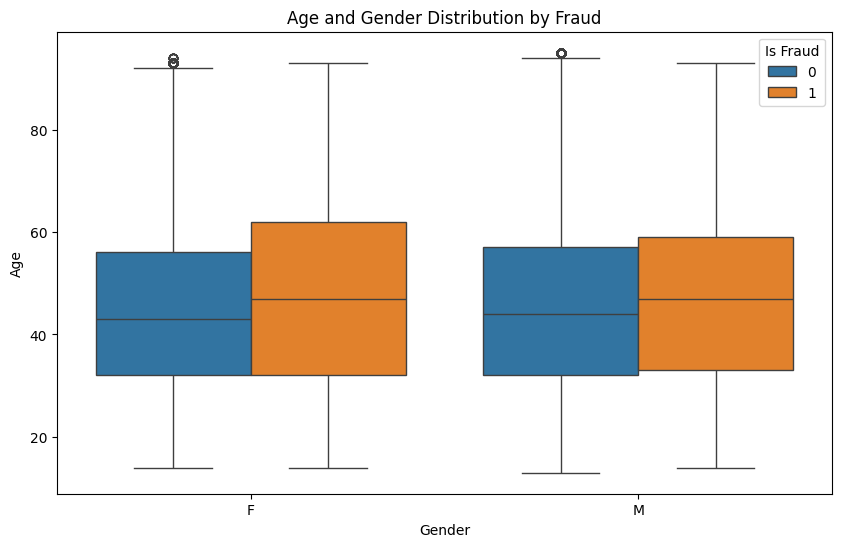

In [21]:
# Age and Gender Analysis
train_data['dob'] = pd.to_datetime(train_data['dob'])
train_data['age'] = (train_data['trans_date_trans_time'] - train_data['dob']).dt.days // 365
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', hue='is_fraud', data=train_data)
plt.title('Age and Gender Distribution by Fraud')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Is Fraud')
plt.show()

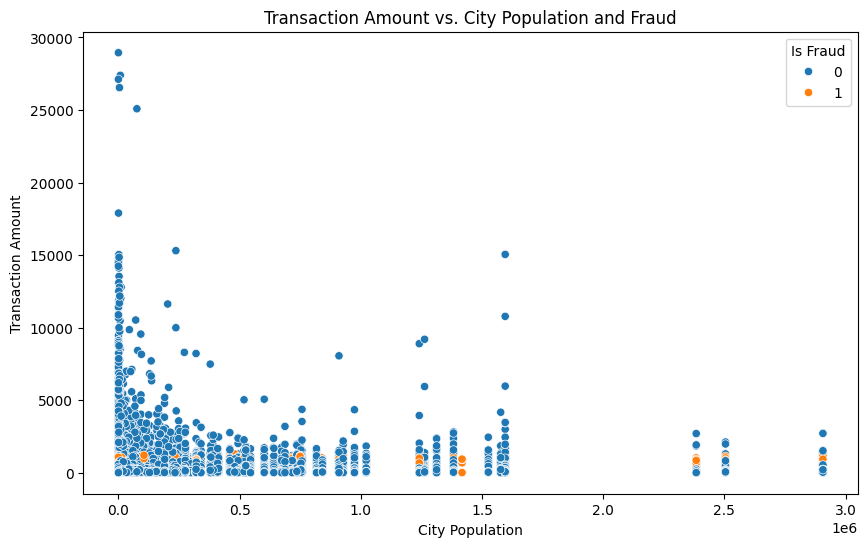

In [22]:
# Transaction Amount vs. City Population
plt.figure(figsize=(10, 6))
sns.scatterplot(x='city_pop', y='amt', hue='is_fraud', data=train_data)
plt.title('Transaction Amount vs. City Population and Fraud')
plt.xlabel('City Population')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud')
plt.show()

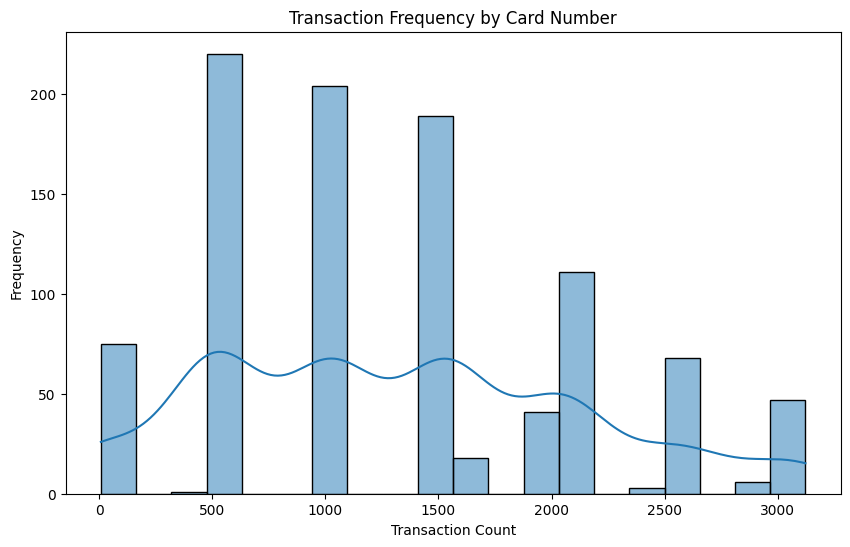

In [23]:
# Transaction Frequency by Card Number
card_transaction_counts = train_data['cc_num'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(card_transaction_counts, bins=20, kde=True)
plt.title('Transaction Frequency by Card Number')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.show()

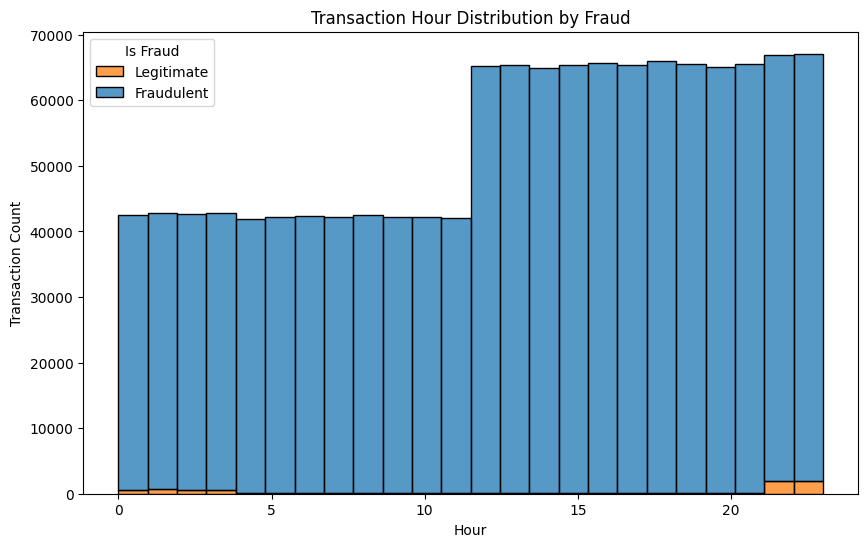

In [24]:
# Transaction Time and Fraud Correlation
train_data['trans_hour'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.hour
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='trans_hour', hue='is_fraud', multiple='stack', bins=24)
plt.title('Transaction Hour Distribution by Fraud')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.legend(title='Is Fraud', labels=['Legitimate', 'Fraudulent'])  # Specify legend labels
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [26]:
# Encode categorical variables
encoder = OneHotEncoder(drop='first')
categorical_cols = ['gender', 'category', 'state']
encoded_train_features = encoder.fit_transform(train_data[categorical_cols]).toarray()
encoded_test_features = encoder.transform(test_data[categorical_cols]).toarray()

# Feature scaling
scaler = StandardScaler()
numerical_cols = ['amt', 'lat', 'long','city_pop', 'unix_time', 'merch_lat', 'merch_long']
scaled_train_features = scaler.fit_transform(train_data[numerical_cols])
scaled_test_features = scaler.transform(test_data[numerical_cols])


# Concatenate encoded and scaled features for both train and test data
final_train_features = pd.concat([pd.DataFrame(encoded_train_features), pd.DataFrame(scaled_train_features)], axis=1)
final_test_features = pd.concat([pd.DataFrame(encoded_test_features), pd.DataFrame(scaled_test_features)], axis=1)

# Define target variables
train_target = train_data['is_fraud']
test_target = test_data['is_fraud']

In [27]:
# Generating synthetic data to balance the imbalanced dataset
smote = SMOTE(random_state=36)

x_train_resample, y_train_resample = smote.fit_resample(final_train_features, train_target)

In [28]:
# checking newly created data
print('Current length of the training set: ', len(y_train_resample))

Current length of the training set:  2578338


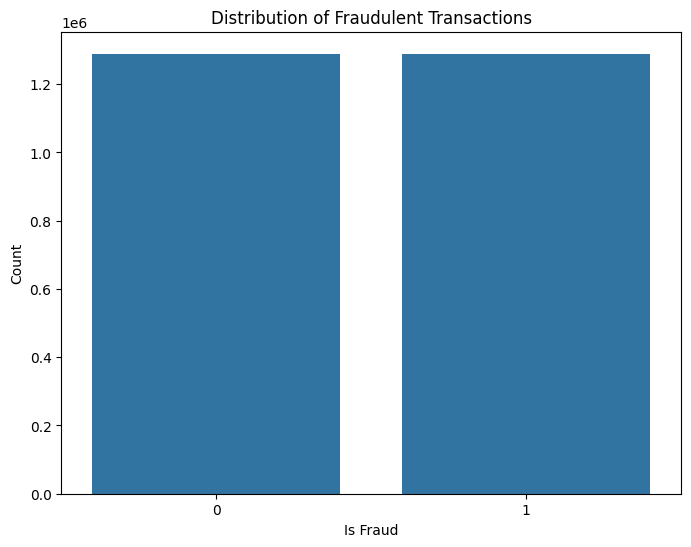

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resample)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

In [30]:
X_shuffled, y_shuffled = shuffle(x_train_resample, y_train_resample, random_state=42)

In [31]:
x_train, x_validation, y_train, y_validation = train_test_split(X_shuffled, y_shuffled, test_size=0.5)

In [32]:
# for the initial selection process we will use a tiny
# portion of the actual training dataset
x_train_copy = x_train
y_train_copy = y_train

x_train = x_train[:10000]
y_train = y_train[:10000]

In [33]:
# Train Logistic Regression model
lg_model = LogisticRegression()
lg_model.fit(x_train, y_train)

# Make predictions on test data
lg_predictions = lg_model.predict(x_validation)

# Calculate evaluation metrics on test data
lg_accuracy = accuracy_score(y_validation, lg_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("Logistic Regression Accuracy: {:.3f}%".format(lg_accuracy * 100))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 81.693%


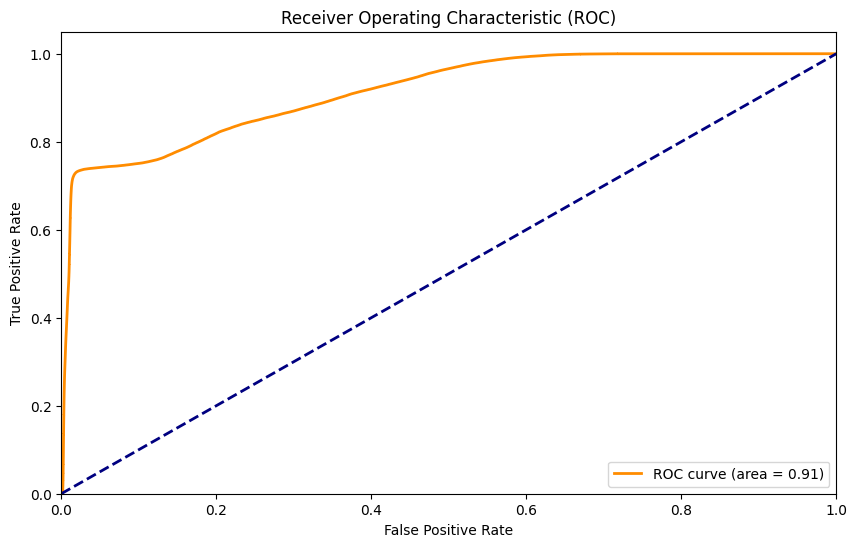

In [34]:
# Calculate ROC curve and AUC
probs = lg_model.predict_proba(x_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


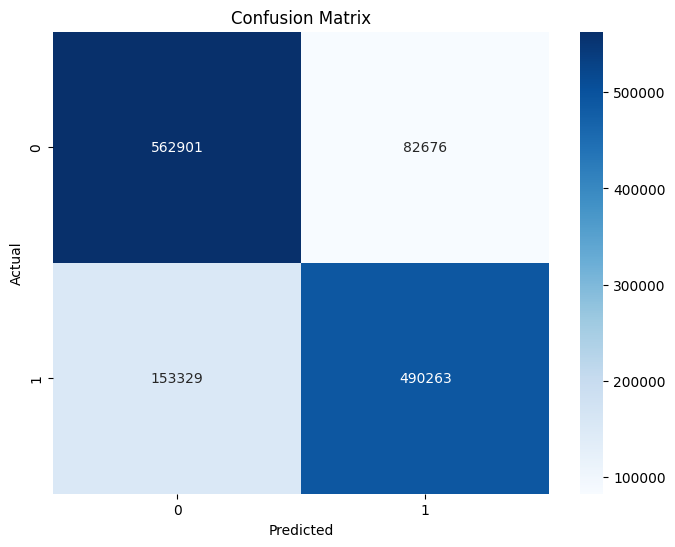

In [35]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, lg_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [36]:
# Train SVM model
from sklearn.svm import SVC
svm_model = SVC(kernel='poly')
svm_model.fit(x_train, y_train)

# Make predictions on test data
svm_predictions = svm_model.predict(x_validation)

# Calculate evaluation metrics on test data
svm_accuracy = accuracy_score(y_validation, svm_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("SVM Accuracy: {:.3f}%".format(svm_accuracy * 100))

SVM Accuracy: 86.093%


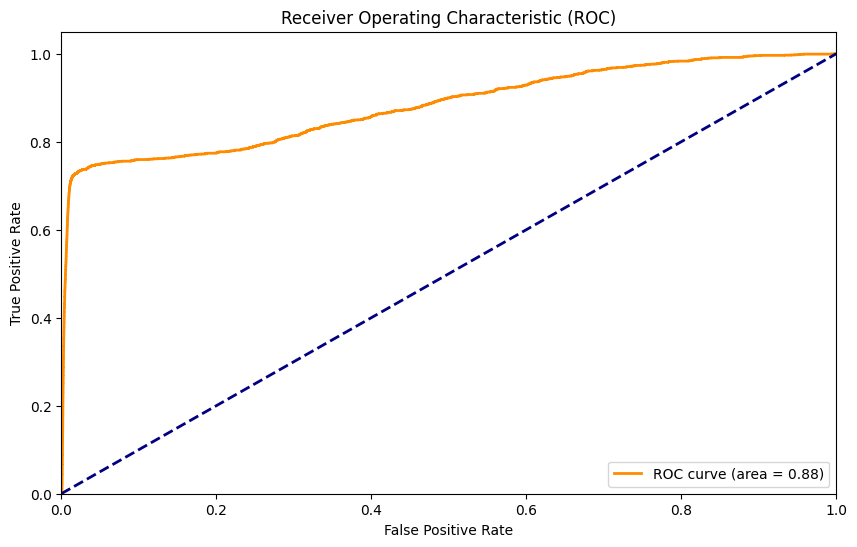

In [37]:
# Calculate decision scores for the positive class
decision_scores = svm_model.decision_function(final_test_features)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_target, decision_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

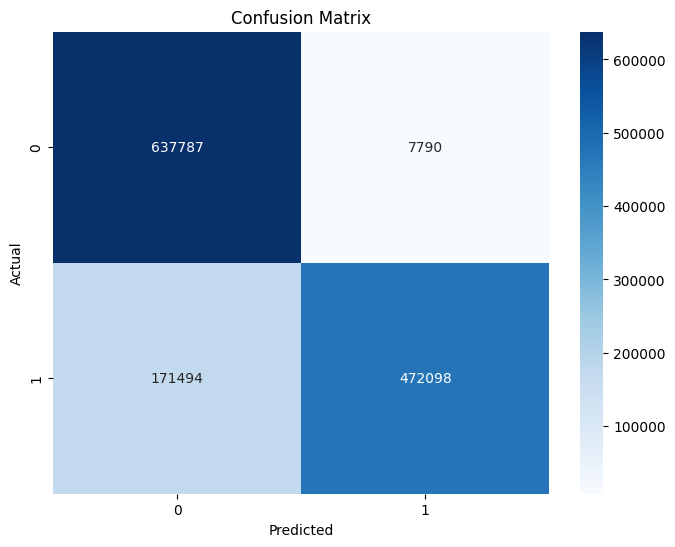

In [38]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [39]:
# Train KNN model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
# Make predictions on test data
knn_predictions = knn_model.predict(x_validation)

# Calculate evaluation metrics on test data
knn_accuracy = accuracy_score(y_validation, knn_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("KNN Accuracy: {:.3f}%".format(knn_accuracy * 100))

KNN Accuracy: 87.663%


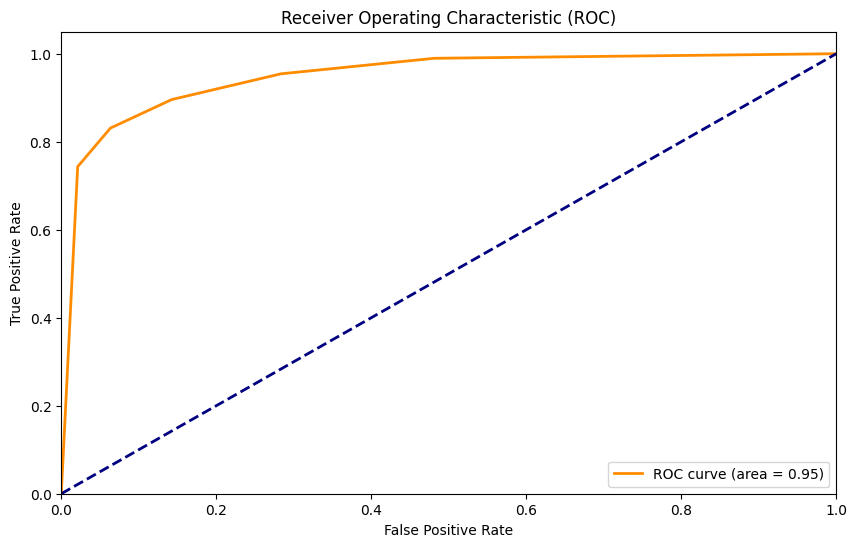

In [40]:
# Calculate ROC curve and AUC
probs = knn_model.predict_proba(x_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

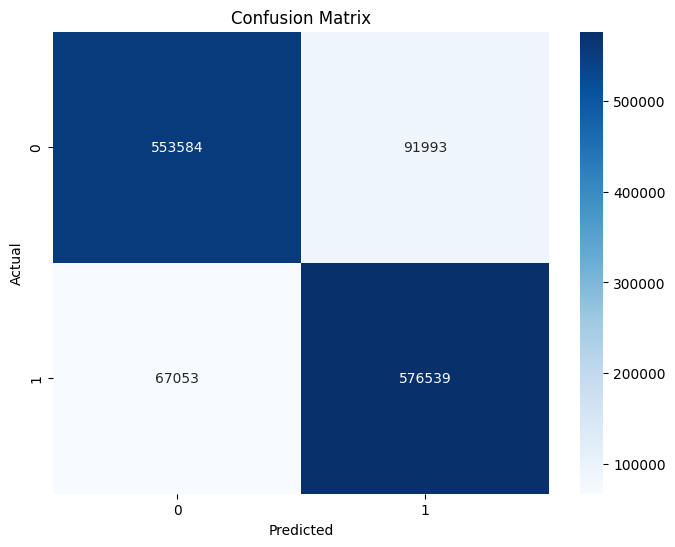

In [41]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, knn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
# Make predictions on test data
rf_predictions = rf_model.predict(x_validation)

# Calculate evaluation metrics on test data
rf_accuracy = accuracy_score(y_validation, rf_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("Random Forest Accuracy: {:.3f}%".format(rf_accuracy * 100))


Random Forest Accuracy: 97.512%


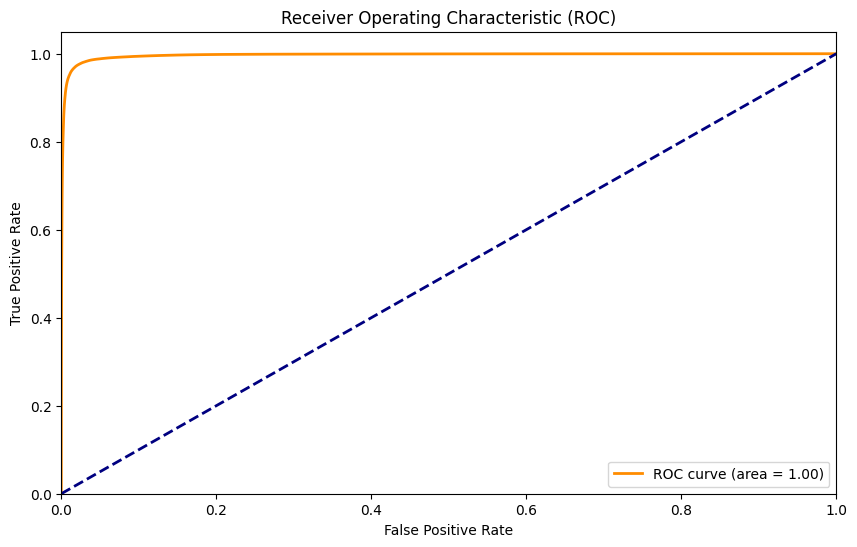

In [43]:
# Calculate ROC curve and AUC
probs = rf_model.predict_proba(x_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

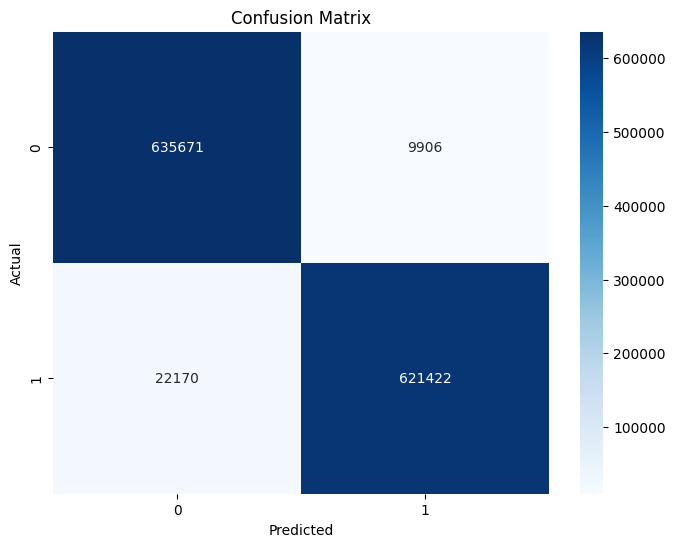

In [44]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
# Train MLP model
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(x_train, y_train)

# Make predictions on test data
mlp_predictions = mlp_model.predict(x_validation)

# Calculate evaluation metrics on test data
mlp_accuracy = accuracy_score(y_validation, mlp_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("MLP Accuracy: {:.3f}%".format(mlp_accuracy * 100))


MLP Accuracy: 95.323%


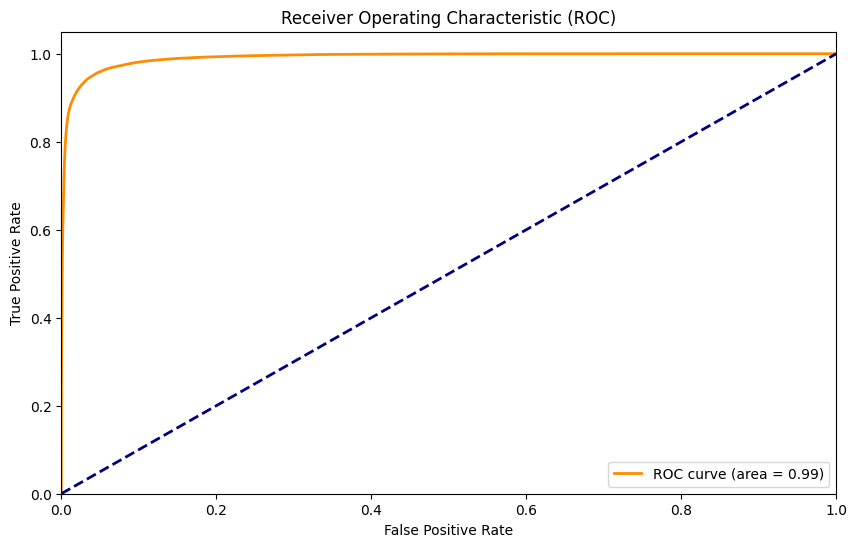

In [46]:
# Calculate ROC curve and AUC
probs = mlp_model.predict_proba(x_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

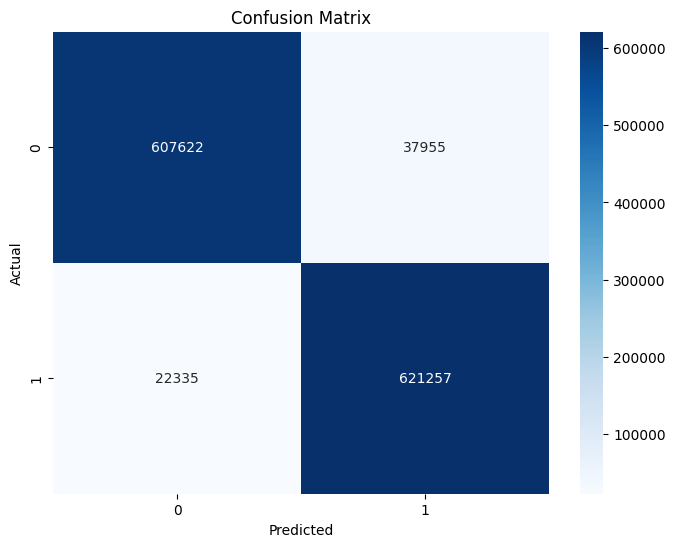

In [47]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, mlp_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
from sklearn.linear_model import SGDClassifier

# Train SGD model
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(x_train, y_train)
# Make predictions on test data
sgd_predictions = sgd_model.predict(x_validation)

# Calculate evaluation metrics on test data
sgd_accuracy = accuracy_score(y_validation, sgd_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("SGD Accuracy: {:.3f}%".format(sgd_accuracy * 100))

SGD Accuracy: 85.776%


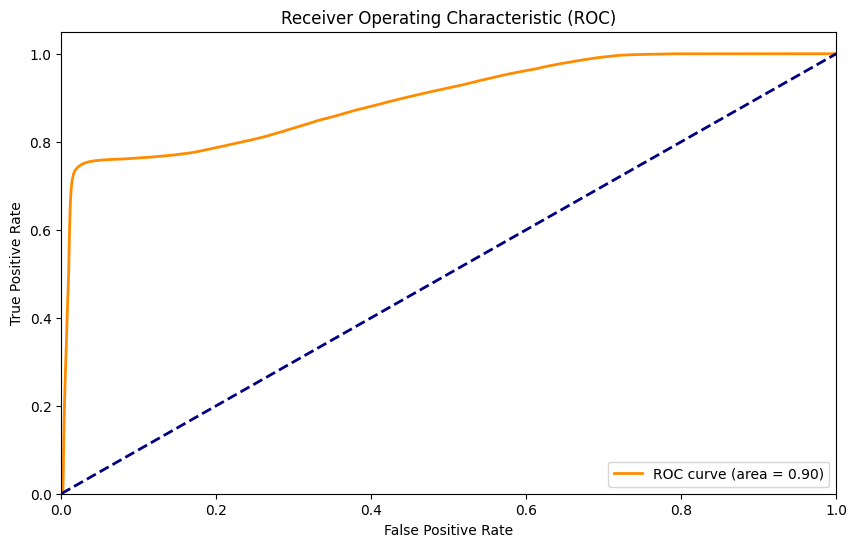

In [49]:
# Calculate decision scores for the positive class
decision_scores = sgd_model.decision_function(x_validation)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, decision_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


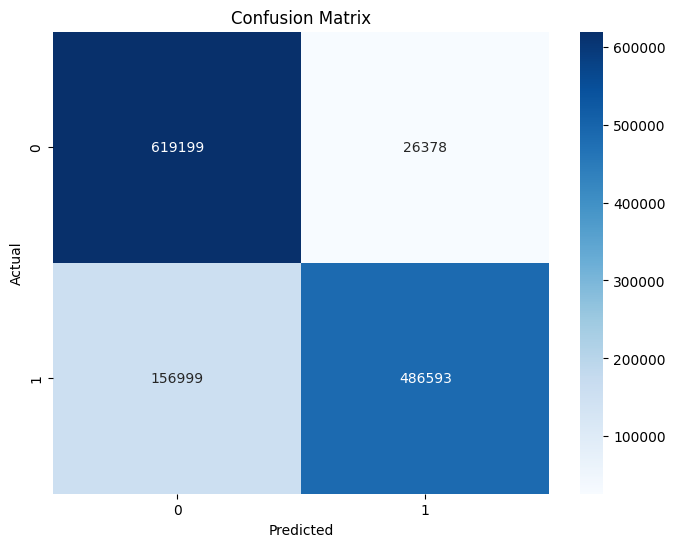

In [50]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, sgd_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
from sklearn.ensemble import ExtraTreesClassifier

# Train Extra Trees model
extra_trees_model = ExtraTreesClassifier(random_state=42)
extra_trees_model.fit(x_train, y_train)

# Make predictions on test data
ext_predictions = extra_trees_model.predict(x_validation)

# Calculate evaluation metrics on test data
ext_accuracy = accuracy_score(y_validation, ext_predictions)


# Print evaluation metrics with 3 decimal places, multiplied by 100
print("Extra Tree Accuracy: {:.3f}%".format(ext_accuracy * 100))


Extra Tree Accuracy: 97.346%


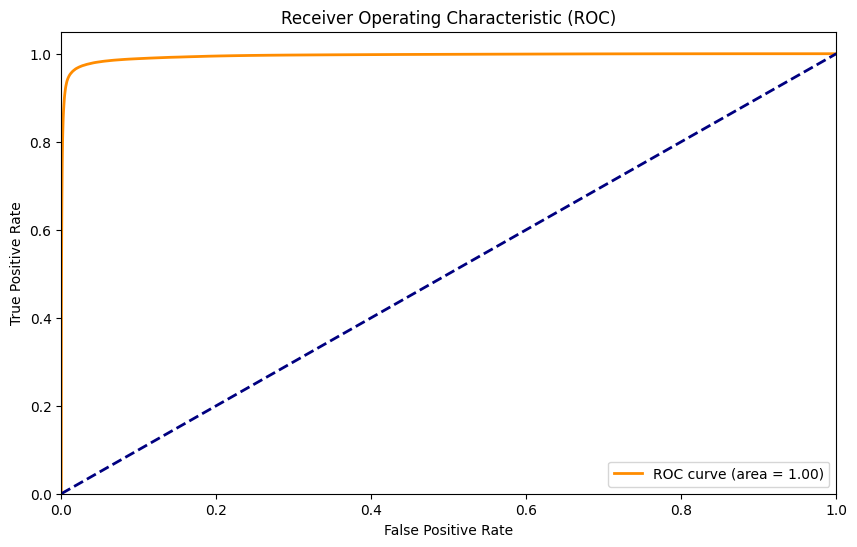

In [52]:
# Calculate ROC curve and AUC
probs = extra_trees_model.predict_proba(x_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

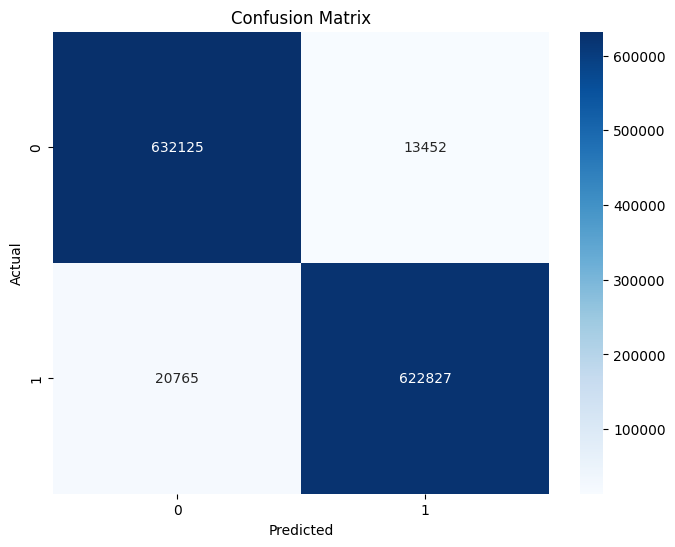

In [53]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_validation, ext_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [54]:
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Define model names and instances
model_names = ['Logistic Regression', 'SVM', 'KNN', 'Random Forest', 'MLP', 'SGD', 'Extra Trees']
model_instances = [lg_model, svm_model, knn_model, rf_model, mlp_model, sgd_model, extra_trees_model]

# Initialize lists to store accuracy and ROC scores
accuracy_scores = []
roc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Calculate accuracy and ROC scores for each model
for model in model_instances:
    predictions = model.predict(final_test_features)
    accuracy = accuracy_score(test_target, predictions)
    roc_score = roc_auc_score(test_target, predictions)
    accuracy_scores.append(accuracy)
    roc_scores.append(roc_score)
    f1_scores.append(f1_score(test_target, predictions))
    precision_scores.append(precision_score(test_target, predictions))
    recall_scores.append(recall_score(test_target, predictions))

# Create a DataFrame to compare results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'ROC Score': roc_scores,
    'F1 Score': f1_scores,
    'Precision Score': precision_scores,
    'Recall Score': recall_scores,
})

# Print the comparison table
print(results_df)


                 Model  Accuracy  ROC Score  F1 Score  Precision Score  \
0  Logistic Regression  0.901202   0.815503  0.053901         0.027985   
1                  SVM  0.968941   0.853451  0.154833         0.086502   
2                  KNN  0.840279   0.808375  0.036160         0.018511   
3        Random Forest  0.984740   0.918502  0.301137         0.182901   
4                  MLP  0.942255   0.892765  0.101271         0.053872   
5                  SGD  0.885201   0.817456  0.047963         0.024775   
6          Extra Trees  0.979725   0.904143  0.239692         0.140129   

   Recall Score  
0      0.729138  
1      0.737063  
2      0.776224  
3      0.851748  
4      0.842890  
5      0.749184  
6      0.827972  
